<a href="https://colab.research.google.com/github/d-atallah/implicit_gender_bias/blob/main/jaymefis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [159]:
import gensim.downloader as api
from gensim.matutils import cossim
from gensim.models import KeyedVectors
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import distance_metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load Files

**Annotations** contains crowdsourced annotations for response sentiment and relevance on source-response pairs obtained as described in the paper *RtGender: A Corpus for Studying Differential Responses to Gender* by Rob Voigt, David Jurgens, Vinodkumar Prabhakaran, Dan Jurafsky and Yulia Tsvetkov. Documentation is available [here](https://nlp.stanford.edu/robvoigt/rtgender/).

In [153]:
file_path_annotations = '/content/drive/MyDrive/SIADS 696: Milestone II/Project/Data/RtGender/annotations.csv'
file_path_googlenews = '/content/drive/MyDrive/SIADS 696: Milestone II/Project/Data/RtGender/word2vec-google-news-300.model'
file_path_document_bias = '/content/drive/MyDrive/SIADS 696: Milestone II/Project/Data/RtGender/document-bias.csv'

In [3]:
dataframe_annotations = pd.read_csv(file_path_annotations)
dataframe_annotations.head()

,source,op_gender,post_text,response_text,sentiment,relevance
0,facebook_wiki,W,Stopped by Fashion Week and got to hang with A...,You are Both Sweet Ashley Tisdale and Lauren C...,Positive,Poster
1,facebook_wiki,M,"Well guys, real progress is happening. I'm 50 ...",Give us the first page to read. ONE PAGE.,Mixed,Content
2,facebook_wiki,W,Tonight is going to be a good night #PerfectMo...,this is my city was there 2 weeks a go,Neutral,Content
3,facebook_wiki,M,I know grandma Gilmore is real proud of you ht...,if grizzly Adams had a beard.,Neutral,Content
4,facebook_wiki,W,#NEWS to KNOW this AM - Mayor Emanuel will mak...,"Good morning Lourdes, have a great day! Great ...",Positive,Irrelevant


**Google News** contains a pre-trained Word2Vec model based on the Google News dataset, covering approximately 3 million words and phrases. Documentation is available [here](https://code.google.com/archive/p/word2vec/) and [here](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py).

In [4]:
# model_googlenews = api.load('word2vec-google-news-300')
# model_googlenews.save(file_path_googlenews)

In [5]:
model_googlenews = KeyedVectors.load(file_path_googlenews, mmap='r')

In [6]:
for index, word in enumerate(model_googlenews.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model_googlenews.index_to_key)} is {word}")

word #0/3000000 is </s>
word #1/3000000 is in
word #2/3000000 is for
word #3/3000000 is that
word #4/3000000 is is
word #5/3000000 is on
word #6/3000000 is ##
word #7/3000000 is The
word #8/3000000 is with
word #9/3000000 is said


In [7]:
model_googlenews.most_similar('she')

[('her', 0.7834683060646057),
 ('She', 0.7553189396858215),
 ('herself', 0.669890820980072),
 ('hers', 0.6509943008422852),
 ('he', 0.612994909286499),
 ('woman', 0.5641393661499023),
 ('Rivadineira', 0.558593213558197),
 ('Jana_Bobek', 0.5365386605262756),
 ('mother', 0.5349627137184143),
 ("she'sa", 0.5337814688682556)]

In [8]:
model_googlenews.most_similar('he')

[('He', 0.6712614297866821),
 ('him', 0.6681135892868042),
 ('his', 0.6201768517494202),
 ('she', 0.612994909286499),
 ('himself', 0.588027834892273),
 ('nobody', 0.5637064576148987),
 ('I', 0.555713951587677),
 ('it', 0.5354882478713989),
 ('never', 0.5239652395248413),
 ('somebody', 0.5205153822898865)]

Nouns from v1.1 of the **HolisticBias** dataset, a project of the Responsible Natural Language Processing team at Facebook Research. The dataset is described in the paper **"I'm sorry to hear that": Finding New Biases in Language Models with a Holistic Descriptor Dataset** by Eric Michael Smith, Melissa Hall, Melanie Kambadur, Eleonora Presani, and Adina Williams. Documentation is available [here](https://github.com/facebookresearch/ResponsibleNLP/tree/main/holistic_bias/dataset/v1.1).

In [9]:
nouns = {
    "female": [
        ["woman", "women"],
        ["lady", "ladies"],
        ["gal", "gals"],
        ["girl", "girls"],
        ["mother", "mothers"],
        ["mom", "moms"],
        ["daughter", "daughters"],
        ["wife", "wives"],
        ["grandmother", "grandmothers"],
        ["grandma", "grandmas"],
        ["sister", "sisters"],
        ["sista", "sistas"]
    ],
    "male": [
        ["man", "men"],
        ["bro", "bros"],
        ["guy", "guys"],
        ["boy", "boys"],
        ["father", "fathers"],
        ["dad", "dads"],
        ["son", "sons"],
        ["husband", "husbands"],
        ["grandfather", "grandfathers"],
        ["grandpa", "grandpas"],
        ["brother", "brothers"]
    ],
    "neutral": [
        ["individual", "individuals"],
        ["person", "people"],
        ["kid", "kids"],
        ["parent", "parents"],
        ["child", "children"],
        ["spouse", "spouses"],
        ["grandparent", "grandparents"],
        ["sibling", "siblings"],
        ["veteran", "veterans"]
    ]
}

In [10]:
data_holisticbias = [[gender, ' '.join([word for pair in words_list for word in pair])] for gender, words_list in nouns.items()]
dataframe_holisticbias = pd.DataFrame(data_holisticbias, columns=['gender', 'text'])
dataframe_holisticbias

,gender,text
0,female,woman women lady ladies gal gals girl girls mo...
1,male,man men bro bros guy guys boy boys father fath...
2,neutral,individual individuals person people kid kids ...


## Tokenize Text

In [11]:
stop_words = text.ENGLISH_STOP_WORDS
print(sorted(stop_words))

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 'further', 'get', 'give

Several of the stop words in scikit-learn encode gender, including he, him, his, and himself (male); she, her, hers, herself (female); and potentially they, them, their, and themselves (nonbinary). It might be preferable to retain stop words and set a maximum document frequency.

In [96]:
def initialize_vectorizer(vectorizer):
    """
    Initializes and configures an instance of a vectorizer class.

    This function takes a vectorizer class (such as CountVectorizer or TfidfVectorizer
    from sklearn.feature_extraction.text) and initializes it with specific configuration
    parameters.

    Args:
        vectorizer (class): The class of the vectorizer to be initialized.

    Returns:
        object: An instance of the specified vectorizer class with configured parameters.
    """

    # Initialize the vectorizer with specific configuration settings
    instance = vectorizer(
        strip_accents='unicode',
        lowercase=False,
        stop_words=None,
        ngram_range=(1, 1),
        min_df=1,
        max_df=1,
        max_features=None
    )

    return instance

In [97]:
def tokenize_text(dataframe, label_column, text_column, vectorizer):
    """
    Tokenizes text data in a pandas DataFrame using a specified vectorizer.

    Args:
    - dataframe (pd.DataFrame): The DataFrame containing the text data.
    - label_column (str): The name of the column containing the labels.
    - text_column (str): The name of the column containing the text to be tokenized.
    - vectorizer (Vectorizer): An instance of a text vectorization class from sklearn.

    Returns:
    - matrix (sparse matrix): The transformed text data as a matrix.
    - labels (pd.Series): The labels associated with the text data.
    - features (np.ndarray): The features associated with the text data.
    """
    # Remove rows with missing values in the text column
    dataframe = dataframe.dropna(subset=[text_column])

    # Transform the text column into a matrix
    matrix = vectorizer.fit_transform(dataframe[text_column])

    # Extract the target variable
    labels = dataframe[label_column]

    # Extract feature names
    features = vectorizer.get_feature_names_out()

    return matrix, labels, features

In [98]:
# Initialize vectorizers
count_vectorizer = initialize_vectorizer(CountVectorizer)
tfidf_vectorizer = initialize_vectorizer(TfidfVectorizer)

In [99]:
# Tokenize posts
matrix_count, labels_count, features_count = tokenize_text(dataframe_annotations, 'op_gender', 'response_text', count_vectorizer)
matrix_tfidf, labels_tfidf, features_tfidf = tokenize_text(dataframe_annotations, 'op_gender', 'response_text', tfidf_vectorizer)

In [100]:
# Tokenize nouns
gender_matrix_count = count_vectorizer.transform(dataframe_holisticbias['text'])
gender_matrix_tfidf = tfidf_vectorizer.transform(dataframe_holisticbias['text'])

## Get Embeddings

In [101]:
def get_embeddings(model, vectorizer):
    """
    Pre-computes word embeddings for the entire vocabulary.

    Args:
    - model (Word2Vec KeyedVectors): Pre-trained Word2Vec model.
    - vocabulary (list of str): The list of words in the vocabulary.

    Returns:
    - dict: A dictionary mapping words to their respective embeddings.
    """
    vocabulary = vectorizer.vocabulary_.keys()
    return {word: model[word] for word in vocabulary if word in model}

In [102]:
embeddings_count = get_embeddings(model_googlenews, count_vectorizer)
embeddings_tfidf = get_embeddings(model_googlenews, tfidf_vectorizer)

## Apply Word Embeddings

In [128]:
def get_word2vec_vector(matrix, features, embeddings, dimensions=300):
    """
    Generate normalized Word2Vec vectors for documents in a given matrix.

    Args:
    matrix (sparse matrix): A matrix where each row represents a document and each column represents a feature.
    features (np.ndarray): An array of words corresponding to the columns in the matrix.
    model (Word2Vec KeyedVectors): Pre-trained Word2Vec model.
    dimensions (int): Dimensionality of the Word2Vec vectors.

    Yields:
    np.ndarray: Normalized Word2Vec vector for each document.
    """
    # Get the number of documents in the matrix
    num_documents = matrix.shape[0]

    # Iterate over each document in the matrix
    for i in range(num_documents):
        # Initialize the vector for the current document
        document_vector = np.zeros(dimensions)
        # Initialize the total weight for the current document
        document_weight = 0

        # Iterate over each word in the features list
        for j, word in enumerate(features):
            # Check if the word is in the model
            if word in embeddings:
                # Get the weight of the word in the current document
                word_weight = matrix[i, j]
                # Get the vector representation of the word and scale it by its weight
                word_vector = embeddings[word] * word_weight
                # Add the weighted word vector to the document vector
                document_vector += word_vector
                # Accumulate the total weight of the words in the document
                document_weight += word_weight

        # Avoid division by zero
        document_weight = document_weight if document_weight > 0 else 1

        # Yield the normalized document vector
        yield document_vector / document_weight

Garg et al. (2018) use a different approach to assess the similarity between a set of neutral words and two groups, first subtracting the distance between each group and a neutral word, then summing the results across words. This approach gives equal weight to each word, unlike the approach above.

## Calculate Bias

In [113]:
def calculate_bias(male_vector, female_vector, document_vector, distance_function=paired_euclidean_distances):
    """
    Calculate the bias in document vectors towards male or female vectors.

    This function computes the distance between a document vector and
    both female and male vectors using either euclidean distance or cosine similarity.
    It returns the difference in distances, which can be interpreted as a bias measure
    towards one of the genders.

    Parameters:
    - male_vector (numpy.ndarray): A vector representing male attributes.
    - female_vector (numpy.ndarray): A vector representing female attributes.
    - document_vector (numpy.ndarray): A vector representing a document.
    - measure (str): The type of distance measure to use ('euclidean' or 'cosine').

    Returns:
    - float: The difference in distances between the document vector
             and the female and male vectors, indicating gender bias.
    """

    # Reshape vectors to 2D arrays to fit the input requirement of distance functions
    female_vector = female_vector.reshape(1, -1)
    male_vector = male_vector.reshape(1, -1)
    document_vector = document_vector.reshape(1, -1)

    # Calculate distance between document and gender vectors
    female_document_distance = distance_function(female_vector, document_vector)
    male_document_distance = distance_function(male_vector, document_vector)

    # Return the difference in distances as a measure of bias
    return float(female_document_distance - male_document_distance)

The advantage of using cosine similarity is that the distance between vectors is normalized. However, because the number of male and female nouns in the HolisticBias dataset is similar, it may not be necessary to use a normalized measure, particularly if computational efficiency is compromised. Garg et al. (2018) use Euclidean distance.

In [129]:
# Get word2vec vectors for male and female nouns
gender_word2vec = get_word2vec_vector(gender_matrix_count, features_count, embeddings_count)
female_vector = next(gender_word2vec)
male_vector = next(gender_word2vec)
neutral_vector = next(gender_word2vec)

# Get word2vec vectors for first five documents
document_word2vec = get_word2vec_vector(matrix_count, features_count, embeddings_count)
document_a = next(document_word2vec)
document_b = next(document_word2vec)
document_c = next(document_word2vec)
document_d = next(document_word2vec)
document_e = next(document_word2vec)

# Calculate bias in first five documents
print(calculate_bias(female_vector, male_vector, document_a))
print(calculate_bias(female_vector, male_vector, document_b))
print(calculate_bias(female_vector, male_vector, document_c))
print(calculate_bias(female_vector, male_vector, document_d))
print(calculate_bias(female_vector, male_vector, document_e))

0.25467810140167524
0.2830669711904008
0.2830669711904008
0.05021823766561173
0.2830669711904008


In [143]:
document_word2vec = get_word2vec_vector(matrix_count, features_count, embeddings_count)
document_bias = np.zeros(int(matrix_count.shape[0]))
for i, document in tqdm(enumerate(document_word2vec)):
  document_bias[i] = calculate_bias(female_vector, male_vector, document)

15350it [1:59:39,  2.14it/s]


In [146]:
len(document_bias)

15350

In [154]:
dataframe_bias = dataframe_annotations.copy().dropna(subset=['response_text'])
dataframe_bias['bias'] = document_bias
dataframe_bias.sort_values('bias')
dataframe_bias.to_csv(file_path_document_bias)

(array([1.46584592e-03, 7.32922961e-04, 8.79507553e-03, 3.15156873e-02,
        1.00410446e-01, 1.94957508e-01, 3.86983323e-01, 7.24127885e-01,
        1.07593091e+00, 1.17780720e+00, 7.17604871e+00, 2.54324267e-01,
        8.35532175e-02, 2.49193807e-02, 5.13046073e-03, 1.46584592e-03,
        0.00000000e+00, 7.32922961e-04, 0.00000000e+00, 1.46584592e-03]),
 array([-0.64557869, -0.5566927 , -0.46780672, -0.37892073, -0.29003475,
        -0.20114876, -0.11226277, -0.02337679,  0.0655092 ,  0.15439518,
         0.24328117,  0.33216715,  0.42105314,  0.50993913,  0.59882511,
         0.6877111 ,  0.77659708,  0.86548307,  0.95436905,  1.04325504,
         1.13214103]),
 <BarContainer object of 20 artists>)

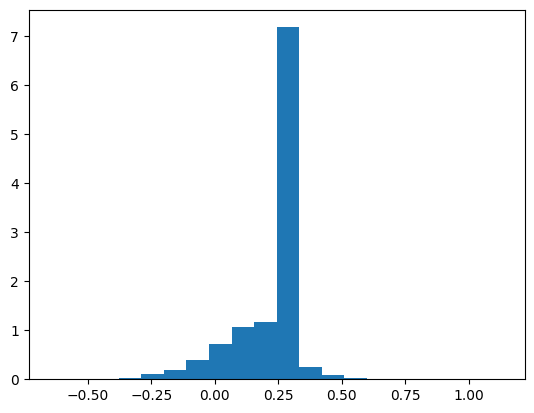

In [179]:
plt.hist(document_bias, bins=20, density=True)

(array([1.63274319e-03, 9.79645917e-03, 2.93893775e-02, 9.14336189e-02,
        1.79601751e-01, 3.34712355e-01, 5.43703484e-01, 8.80048582e-01,
        1.18047333e+00, 1.06944679e+00, 7.63633992e+00, 2.51442452e-01,
        9.30663621e-02, 2.61238911e-02, 8.16371597e-03, 1.63274319e-03,
        1.63274319e-03, 0.00000000e+00, 0.00000000e+00, 1.63274319e-03]),
 array([-0.54323691, -0.46220142, -0.38116594, -0.30013046, -0.21909497,
        -0.13805949, -0.057024  ,  0.02401148,  0.10504696,  0.18608245,
         0.26711793,  0.34815342,  0.4291889 ,  0.51022438,  0.59125987,
         0.67229535,  0.75333084,  0.83436632,  0.9154018 ,  0.99643729,
         1.07747277]),
 <BarContainer object of 20 artists>)

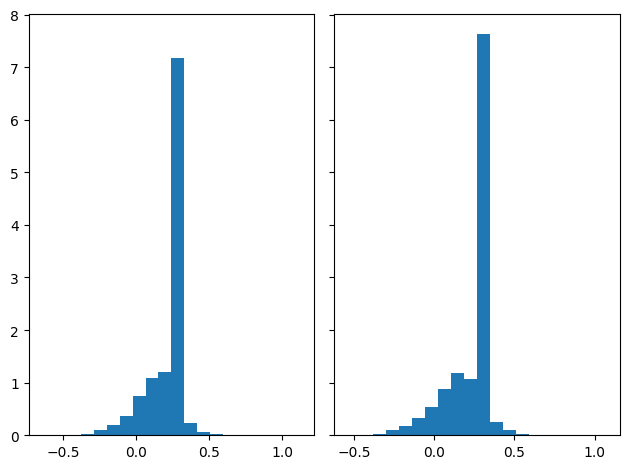

In [180]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(dataframe_bias[dataframe_bias['op_gender'] == 'M']['bias'], bins=20, density=True)
axs[1].hist(dataframe_bias[dataframe_bias['op_gender'] == 'W']['bias'], bins=20, density=True)

## References

"Please annotate the following code and convert it into PEP 8." OpenAI. (2023). ChatGPT (Jan 30 version) [Large language model]. https://chat.openai.com/chat

Garg, N., Schiebinger, L., Jurafsky, D., & Zou, J. (2018). Word embeddings quantify 100 years of gender and ethnic stereotypes. PNAS, 115(16). https://doi.org/10.1073/pnas.1720347115